In [180]:
!pip install -q eccd_datasets category_encoders shap pygradus

In [181]:
STUDENT_NAME = "florencia-britos"
COURSE_NAME = "eccd-oct23"
EXERCISE_NAME = "price-recommendation"

# Objective

Explore how a pricing automation / recommendation project looks like.

In a pricing recommendation problem, often the most accurate prediction is not necessary the most important goal.
Indeed, sometimes offering a range of possible values or an explanation on how a certain variable affects the outcomes can be more useful for an end-user.

We will use a very basic data cleaning of a popular dataset before proceeding.

In [182]:
import pandas as pd
import numpy as np

from eccd_datasets import load_mercari
from category_encoders import TargetEncoder
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import shap

from pygradus import create_exercise, check_solution

In [183]:
df = load_mercari()

In [184]:
df.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
1071845,1071845,PlayStation 1 games,3,Electronics/Video Games & Consoles/Games,Sony,25.0,1,No description yet
1341567,1341567,Cropped Sweater,2,Women/Tops & Blouses/Knit Top,None,9.0,0,-long sleeve -cropped -tight
584822,584822,Color Speaker,3,"Electronics/TV, Audio & Surveillance/Home Spea...",None,16.0,0,"Fantasy color speaker. Has aux, Bluetooth, can..."
197407,197407,⚡️vs pink nation dog⚡️,1,Vintage & Collectibles/Collectibles/Doll,Victoria's Secret,24.0,0,New
904192,904192,Lululemon Mens Shirt,2,Men/Athletic Apparel/Shirts & Tops,Lululemon,35.0,1,"Lululemon Men's Metal vent short sleeve shirt,..."


# Data Cleaning

In this excercise we are going to ignore both `name` and `item_description` categories.

For the `category_name` feature, we are going to split it in three.

Then, we are going to use a categorical encoder to encode all string atributes into numbers.

In [185]:
def split_cat(text):
    try: return text.split("/")
    except: return ("No Label", "No Label", "No Label")

In [186]:
df["cat_1"], df["cat_2"], df["cat_3"] = zip(*df["category_name"].apply(split_cat))

In [187]:
df.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,cat_1,cat_2,cat_3
1071845,1071845,PlayStation 1 games,3,Electronics/Video Games & Consoles/Games,Sony,25.0,1,No description yet,Electronics,Video Games & Consoles,Games
1341567,1341567,Cropped Sweater,2,Women/Tops & Blouses/Knit Top,None,9.0,0,-long sleeve -cropped -tight,Women,Tops & Blouses,Knit Top
584822,584822,Color Speaker,3,"Electronics/TV, Audio & Surveillance/Home Spea...",None,16.0,0,"Fantasy color speaker. Has aux, Bluetooth, can...",Electronics,"TV, Audio & Surveillance",Home Speakers & Subwoofers
197407,197407,⚡️vs pink nation dog⚡️,1,Vintage & Collectibles/Collectibles/Doll,Victoria's Secret,24.0,0,New,Vintage & Collectibles,Collectibles,Doll
904192,904192,Lululemon Mens Shirt,2,Men/Athletic Apparel/Shirts & Tops,Lululemon,35.0,1,"Lululemon Men's Metal vent short sleeve shirt,...",Men,Athletic Apparel,Shirts & Tops


In [188]:
df = df[[
    "item_condition_id", "brand_name", "shipping", "cat_1", "cat_2", "cat_3", "price"
]]

In [189]:
df.head()

,item_condition_id,brand_name,shipping,cat_1,cat_2,cat_3,price
1071845,3,Sony,1,Electronics,Video Games & Consoles,Games,25.0
1341567,2,None,0,Women,Tops & Blouses,Knit Top,9.0
584822,3,None,0,Electronics,"TV, Audio & Surveillance",Home Speakers & Subwoofers,16.0
197407,1,Victoria's Secret,0,Vintage & Collectibles,Collectibles,Doll,24.0
904192,2,Lululemon,1,Men,Athletic Apparel,Shirts & Tops,35.0


# Data preparation

As always, we divide our dataset into a training and test datasets.

We fix the `random_seed` to make sure that our experiment is reproducible!

In [190]:
y = df.pop("price")
X = df.copy()

In [191]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, shuffle=True)

In [192]:
X_train.head()

,item_condition_id,brand_name,shipping,cat_1,cat_2,cat_3
1181562,3,LuLaRoe,1,Women,Tops & Blouses,Tunic
1060152,1,None,0,Women,Tops & Blouses,T-Shirts
339643,1,James Avery,1,Women,Jewelry,Bracelets
159854,3,None,0,Women,Tops & Blouses,Button Down Shirt
1452651,1,PINK,1,Women,Underwear,Panties


## Target Encoder

We will proceed to build a target encoder for the columns that still have strings in them

In [194]:
def build_target_encoder(X: pd.DataFrame, y: pd.DataFrame) -> TargetEncoder:
    """
    Train a target encoder on columns "brand_name, "cat_1", "cat_2", "cat_3"
    using the train dataset and return the "fitted" encoder.
    """
    categorical_columns = ["brand_name", "cat_1", "cat_2", "cat_3"]
    encoder = TargetEncoder(cols=categorical_columns)
    encoder.fit(X, y)
    return encoder


In [195]:
te = build_target_encoder(X_train, y_train)

row1 = X_train.iloc[:1]
row1_t = te.transform(row1)

In [196]:
assert np.allclose(row1_t["cat_1"], y_train.loc[X_train["cat_1"] == row1["cat_1"].iloc[0]].mean())

In [197]:
row2 = X_test.iloc[:1]
row2_t = te.transform(row2)
answer_target_encoder = row2_t["cat_2"].values[0]
print("cat_2 target encoder", answer_target_encoder)

cat_2 target encoder 15.01733102253033


In [198]:
answer_target_encoder

15.01733102253033

# Training

For training we are going to use a very popular machine learning model named `LightGBM` from Micrsoft.

One of the advantages of this model is that it includes a `quantile loss` that we can use to obtain intervals.

We will train the models three times, one for each quantile: `10%, 50% (the median) and 90%`.


In [199]:
X_train_t = te.transform(X_train)

params = {
    'objective': 'quantile',
    'metric': 'quantile',
    'max_depth': 4,
    'num_leaves': 15,
    'learning_rate': 0.1,
    'n_estimators': 100,
    'boosting_type': 'gbdt',
    'seed': 42,
    'num_threads': 1
}

quantiles = [.1, .5, .9]

preds = []

for i in range(len(quantiles)):

    reg = lgb.LGBMRegressor(alpha=quantiles[i], **params)

    model = reg.fit(X_train_t, y_train)

    X_test_t = te.transform(X_test)

    y_pred = model.predict(X_test_t)

    preds.append(y_pred)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003289 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 580
[LightGBM] [Info] Number of data points in the train set: 75000, number of used features: 6
[LightGBM] [Info] Start training from score 7.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

Here we process the three predicitions, one for each model and use them to build the corresponding intervals

In [200]:
df_preds = pd.DataFrame(preds).T
df_preds["y_test"] = y_test.values
df_preds.columns = ["q10", "q50", "q90", "y_test"]

In [201]:
df_preds.head()

,q10,q50,q90,y_test
0,4.384853,8.638236,24.631757,5.0
1,8.543613,12.997183,19.070647,10.0
2,20.253245,66.078272,126.439239,120.0
3,6.207722,11.666134,29.587953,9.0
4,8.900193,16.713017,40.405916,59.0


In [202]:
def get_result_within_interval(df_preds: pd.DataFrame) -> int:
    """
    Implement a function that counts for how many
    rows it holds that the true value $y \in [q10, q90]$

    For example, if in a row the real value of the target variable is 10,
    q10 is 5 and q90 is 15, that row counts.
    If in a different row, the target variable is 20, q10 is 5 and q90 is 15,
    that row does not count.
    """
    count = ((df_preds["y_test"] >= df_preds["q10"]) & (df_preds["y_test"] <= df_preds["q90"])).sum()
    return count


In [203]:
answer_interval =  get_result_within_interval(df_preds)
print("Results within interval", answer_interval)

Results within interval 19774


# Shapely value

Finally, we can use the shapley value to obtain an explanation of how each feature contributes to the final prediction.

In a price recommendatino problem this information is very helpful to end-users, possibly even more than the actual price

In [204]:
shap.initjs()

In [205]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_t)

In [206]:
shap_values

array([[  0.16667643,  -4.44645106,  -2.34252477,   6.16277985,
         -4.2807224 , -17.39071193],
       [ -3.37130408, -24.99394881,   1.3552882 ,  -1.75844311,
          1.28925935,  -0.21291539],
       [  3.27362702,  45.62491679,  -1.64654407,  -4.09984777,
          0.79936059,  35.72501502],
       ...,
       [  4.87579313,  -7.02799789,   2.57862025,  -0.96690635,
          1.61835841,  -2.2994111 ],
       [  3.56235508,  -7.42378339,   3.29715163,  -1.55173562,
         -3.1253619 ,   1.33179088],
       [  0.1774405 , -20.56714446,  -1.7202452 ,  -1.24621773,
          0.11420163,  -4.31998606]])

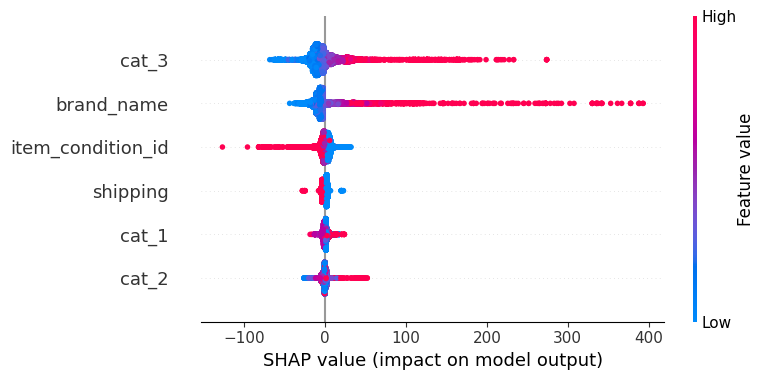

In [207]:
shap.summary_plot(shap_values, X_test_t)

We can also use the Shapley value to predict a single element

In [208]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test_t.iloc[0,:])

In [209]:
# Convierto a int previamente dado que sino al correr el código me daba este error -> Object of type int64 is not JSON serializable
answer_interval = int(answer_interval)

proposed_solution = {
'attempt': {
    'course_name': COURSE_NAME,
    'exercise_name': EXERCISE_NAME,
    'username': STUDENT_NAME,
},
'task_attempts': [
	{
		"name": "target-encoder",
		"answer": answer_target_encoder,
	},
	{
		"name": "results-within-interval",
		"answer": answer_interval,
	},
]

}
check_solution(proposed_solution)


|                    Task Name                     |       Status       |
|--------------------------------------------------|--------------------|
|--------------------------------------------------|--------------------|
|                  target-encoder                  |      Correct       |
|--------------------------------------------------|--------------------|
|             results-within-interval              |      Correct       |
|--------------------------------------------------|--------------------|
